In [4]:
#from ensembles import VanillaEnsemble, BootstrapEnsemble
import ensembles
import importlib
importlib.reload(ensembles)
VanillaEnsemble = ensembles.VanillaEnsemble
BootstrapEnsemble = ensembles.BootstrapEnsemble



from datasets import make_dataset, make_cross_validation_dataset
from plot import plot_dataset, plot_prediction
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 4]
from evaluation import evaluate_model
import tensorflow as tf

# Explanation



Showing the efficiency of two types of ensembles, Vanilla Network Ensemble with different initialisation parameters and Bootstrap Ensemble grown by presenting copies of the exact same model with different subsets of the dataset.

All underlying Estimators are built in tensorflow (1.4) and are based on the same parent object (ToDo: Make this more beautiful and readable). Can be found in /estimators. The Ensembles simulate Online Training rather than actually training online at the moment (ToDo: Rewrite Ensembles to train online properly). The Code can be found in /ensembles.

VanillaEnsemble, which is an ensemble of the class EnsembleNetwork that differ in two significant ways: 
    1. different number of layers 
    2. different initial conditions (translates to different seeds at weight initialisation time)
    3. each of the networks are shown the full dataset
Inspired by an approach used in [1]

    
   
BootstrapEnsemble, which is an ensemble of the class EnsembleNetwork in which each part of the ensemble:
    1. share the exact same hyperparameters
    2. share the same initial conditions (translates to setting the same seed at weight initialisation time)
    3. are each shown  ~ 50% of the Dataset
Expansion of [2] to (kind of) work with Deep Networks 


No Regularisation has been added, thus quite a bit of overfitting occurs.

ToDo:

- add Dropout Ensemble from [3]





# Parameters
parameters have been chosen at 'random', i.e. not much thought has been put into them. No Gridsearch for optimal parameter spaces or similar.

each neural network is contains three hidden layers with 10 neurons each, the learning rate has been set to 0.001 which seems a literature standard (cite needed)

The layers are instantiated by draws from a normal distribution (0,1), for the Bootstrap network a distribution over parameters can be achieved by assuming that each $w_i$ is a draw from a normal distribution. While thinkable in theory, the same is non-trivial for an ensemble with differing hyperparameters (i.e. different number of layers and different layer sizes).

# Dataset 
The Dataset contains 100 samples generated by the function 

$5 \cdot sin(X) + 10 + X^2 + noise$

where X is linearly spaced patches in the intervall [-5,5] the noise is drawn from a normal distribution (0,4)

# Training
Each network is trained on 10 * 100 = 1000 epochs

Training is offline. The datasets are shown to the estimators as a whole (although it should be relatively easy to switch to online) (ToDo: Switch to Online). The Bootstrap in the Bootstrap Estimator is achieved by randomly drawing  sub-datasets that each contain ~ 50% of datapoints.
The optimizer is the standard implementation of tensorflow's tf.train.GradientDescentOptimizer 


# Evaluation
Right now, the RSME and the coverage probability of the prediction is reported, where the data is available (i.e. VanillaNetwork does not return uncertainty = no Coverage). At the moment, evaluation happens on the training set (because the data generating model is a bit annoying to work with because of quite frankly a bit of a stupid shuffling situation, which is on the ToDo list) (ToDo: solve that)

# Problems/ToDo

It's not entirely clear (ToDo: Literature search) what scaling factor should be used for the variance. While the VanillaEnsemble can to a certain extend be influenced by choosing vastly different models (including untouched hyperparameters such as but not limited to _weight initialisation schemes, optimisation algorithms, learning rate,..._, it's not entirely obvious which hyperparameters apart from the number of estimators $p_{keep}$ that regulates the size of the subsampled datasets can be chosen to generate inherently greater (or lower) variance in the samples.

Hyperparameters need to be tuned

No real Online Training

Evaluation on training set (alas only to make a point about uncertainty so maybe can be forgiven in this phase)




[1] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. In Advances in Neural Information Processing Systems (pp. 6405-6416).
Chicago	

Link: https://arxiv.org/abs/1612.01474



[2] Eckles, D., & Kaptein, M. (2014). Thompson sampling with the online bootstrap. arXiv preprint arXiv:1410.4009.

Link: https://arxiv.org/abs/1410.4009


[3] Gal, Y., & Ghahramani, Z. (2016, June). Dropout as a Bayesian approximation: Representing model uncertainty in deep learning. In international conference on machine learning (pp. 1050-1059).

Link: http://proceedings.mlr.press/v48/gal16.html

# Preparations

In [5]:

from global_vars import SEED as seed
#seed = 
data = make_dataset(train_p=0.8,seed=seed)

X = data['X']
y = data['y']
X_test = data['X_test']
y_test = data['y_test']
generate_sinoid = data['generating']
#sorted_index = data['train_index']
sorted_index = data['shuffle_index']
#test_index = data['test_ind']

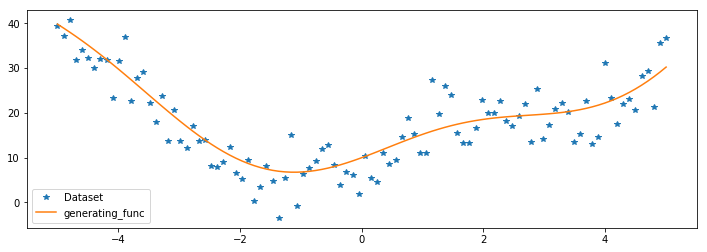

In [6]:
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Initialise Ensembles

In [7]:
num_epochs = 10
num_eps = 75#25#100
#ensemble = [{'num_neurons':[10,10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
#            {'num_neurons':[10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
#            {'num_neurons':[10,10,10,10,10,10],'num_epochs':num_epochs}]#,'optimizer':tf.train.AdamOptimizer}]
        

ensemble = [{'num_neurons':[10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,5,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,5,20],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,5],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10],'num_epochs':num_epochs}]#,'optimizer':tf.train.AdamOptimizer}]
        
    
    
vanilla = VanillaEnsemble(estimator_stats = ensemble)


#bootstrap_ensemble = {'num_neurons':[10,10,10,10,10],'num_epochs':num_epochs}#,'optimizer':tf.train.AdamOptimizer}
bootstrap_ensemble = {'num_neurons':[10,10,10],'num_epochs':num_epochs}#,'optimizer':tf.train.AdamOptimizer}

bootstrap = BootstrapEnsemble(estimator_stats= bootstrap_ensemble)

In [8]:
def get_mean_var(pred_dict):
    return pred_dict['means'],pred_dict['stds']
    

Vanilla Ensemble already displays a measure of uncertainty due to the ensembled models being initialised differently.
Bootstrap Ensemble does not have uncertainty die to the fact that all contained models are initialised in exactly the same way (thus each sample returns the exact same values)

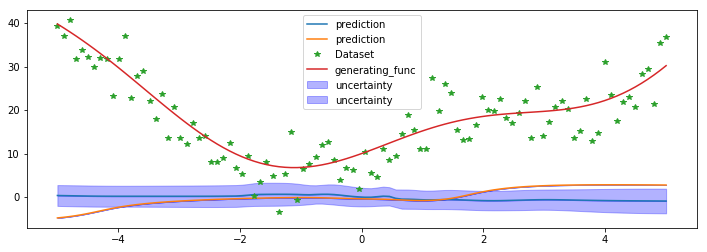

In [9]:
vanilla_pred_dict = vanilla.predict(X)
vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
bootstrap_pred_dict = bootstrap.predict(X)
bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_dict)
plot_prediction(X,
                vanilla_preds,
                sorted_index,
                vanilla_var)

plot_prediction(X,
                bootstrap_preds,
                sorted_index,
                bootstrap_var)

plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Training

## Vanilla Ensemble

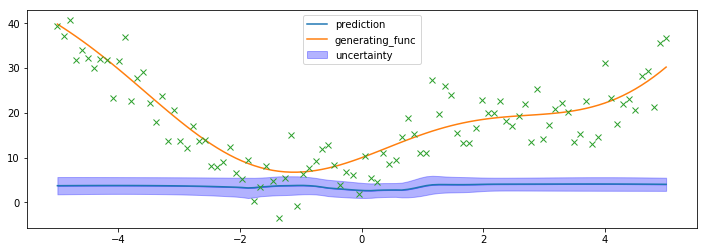

RSME is 16.805986404418945
COVERAGE PROBABILITY is 0.06
MEAN VARIANCE is 1.7612321376800537
COVERAGE/MEAN_VAR is 0.03406705948429589
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.09126451, 0.36649544243641785)


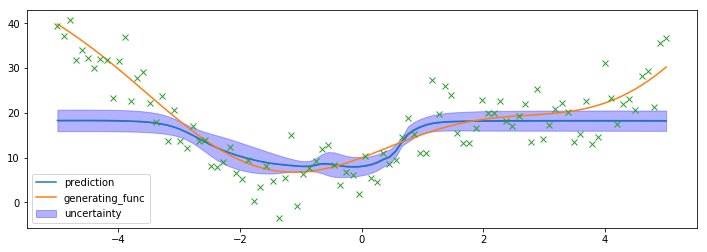

RSME is 7.533097743988037
COVERAGE PROBABILITY is 0.24
MEAN VARIANCE is 2.1658546924591064
COVERAGE/MEAN_VAR is 0.11081075791262088
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.18892059, 0.05977590365018135)


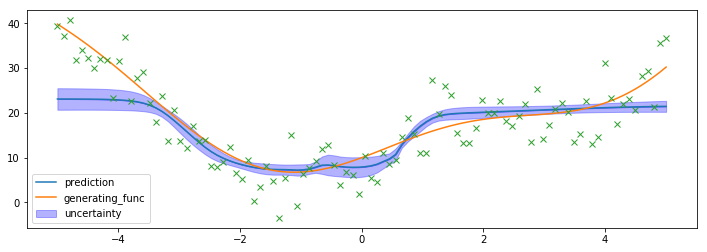

RSME is 5.984682083129883
COVERAGE PROBABILITY is 0.21
MEAN VARIANCE is 1.4196107387542725
COVERAGE/MEAN_VAR is 0.14792787506262303
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34378114, 0.0004618450177412124)


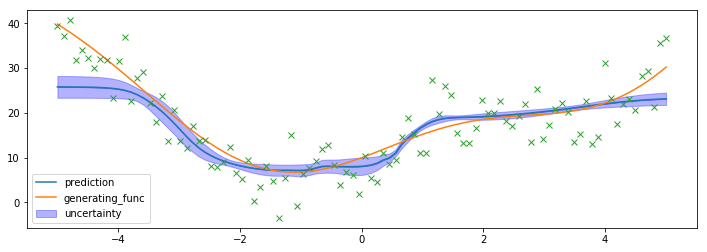

RSME is 5.342342853546143
COVERAGE PROBABILITY is 0.16
MEAN VARIANCE is 1.283137559890747
COVERAGE/MEAN_VAR is 0.12469434688952853
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.24172105, 0.015398660328147743)


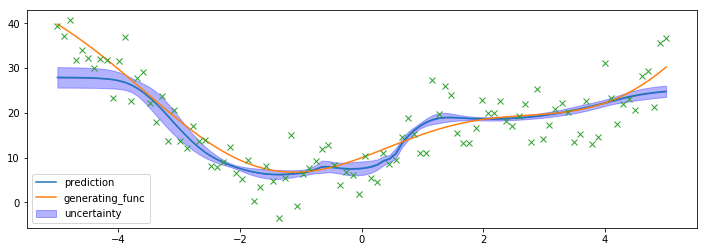

RSME is 4.849635601043701
COVERAGE PROBABILITY is 0.13
MEAN VARIANCE is 1.1589323282241821
COVERAGE/MEAN_VAR is 0.11217220957085339
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.17656726, 0.07886526574591428)
RSME is 4.849635601043701
COVERAGE PROBABILITY is 0.13
MEAN VARIANCE is 1.1589323282241821
COVERAGE/MEAN_VAR is 0.11217220957085339
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.17656726, 0.07886526574591428)


{'NLPD': -9.868330001831055,
 'correlation between error and variance': 0.104158185,
 'coverage probability': 0.16,
 'rsme': 4.6040525}

In [10]:
vanilla_error_list = []
for i in range(num_eps):
    vanilla.train(X,y)
    #errors = vanilla.train_and_evaluate(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #vanilla_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        vanilla_pred_dict = vanilla.predict(X)
        vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
        #vanilla_var = vanilla_var**2
        plot_prediction(X,vanilla_preds,sorted_index,vanilla_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,vanilla_preds,var=vanilla_var)

vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
evaluate_model(X,y,vanilla_preds,var=vanilla_var)

vanilla.self_evaluate(X,y)

In [11]:
#plt.plot(np.squeeze(vanilla_error_list))


## Bootstrap Ensemble

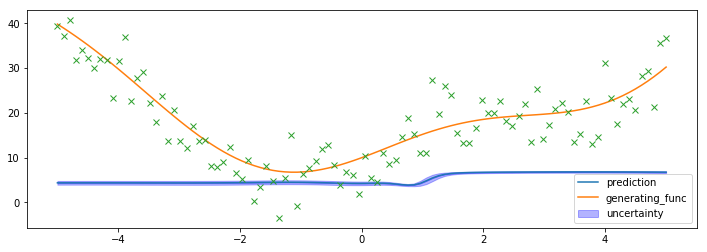

RSME is 15.514591217041016
COVERAGE PROBABILITY is 0.03
MEAN VARIANCE is 0.3403361439704895
COVERAGE/MEAN_VAR is 0.08814814568329038
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.02875689, 0.7764010394576324)


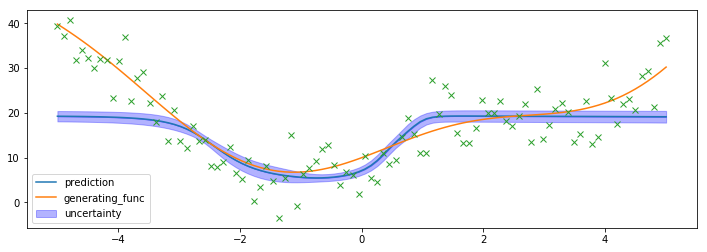

RSME is 7.171961307525635
COVERAGE PROBABILITY is 0.17
MEAN VARIANCE is 1.2400811910629272
COVERAGE/MEAN_VAR is 0.1370877981418988
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.049095772, 0.6276211182203806)


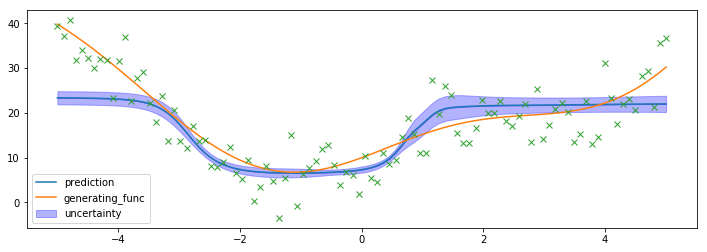

RSME is 5.986399173736572
COVERAGE PROBABILITY is 0.22
MEAN VARIANCE is 1.4694372415542603
COVERAGE/MEAN_VAR is 0.1497171800051158
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.14027245, 0.16392800521759754)


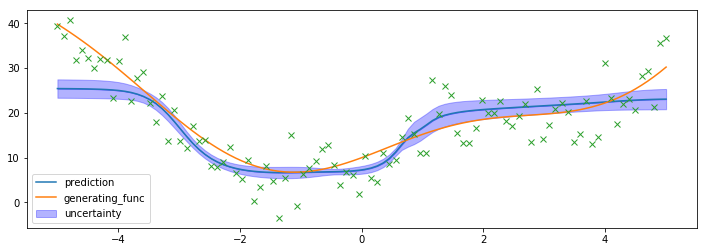

RSME is 5.48549222946167
COVERAGE PROBABILITY is 0.21
MEAN VARIANCE is 1.606651782989502
COVERAGE/MEAN_VAR is 0.1307066050175803
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.32024837, 0.0011613163168586592)


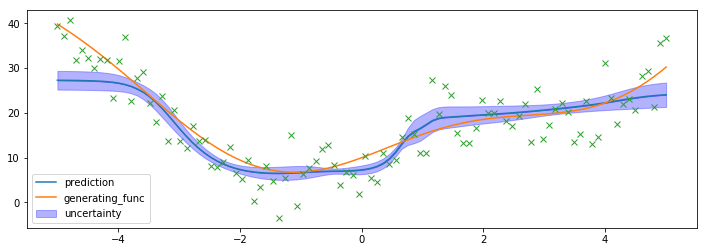

RSME is 5.0374274253845215
COVERAGE PROBABILITY is 0.2
MEAN VARIANCE is 1.6080315113067627
COVERAGE/MEAN_VAR is 0.1243756721144541
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34245434, 0.00048744078387019776)


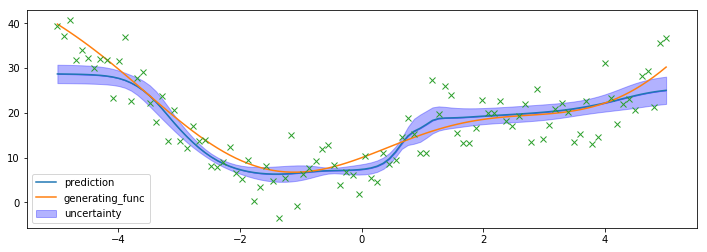

RSME is 4.770401954650879
COVERAGE PROBABILITY is 0.21
MEAN VARIANCE is 1.7512600421905518
COVERAGE/MEAN_VAR is 0.11991365927433764
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3299445, 0.0008012612743302414)


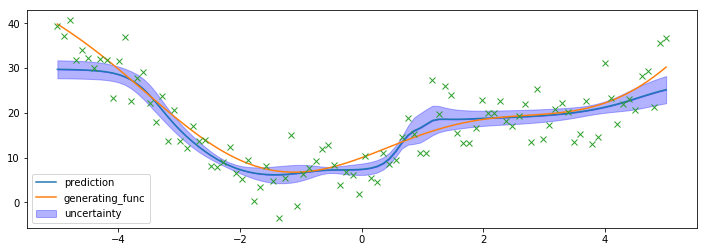

RSME is 4.603695869445801
COVERAGE PROBABILITY is 0.21
MEAN VARIANCE is 1.6836897134780884
COVERAGE/MEAN_VAR is 0.1247260693695109
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.34330934, 0.000470801744684944)


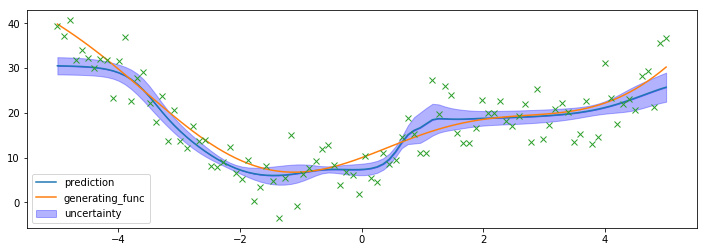

RSME is 4.491309642791748
COVERAGE PROBABILITY is 0.24
MEAN VARIANCE is 1.7385777235031128
COVERAGE/MEAN_VAR is 0.13804387158281123
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3514879, 0.00033602681594847953)


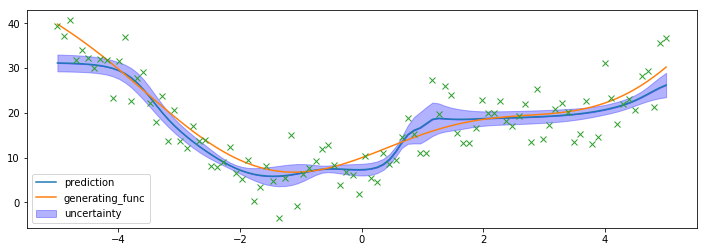

RSME is 4.406518459320068
COVERAGE PROBABILITY is 0.26
MEAN VARIANCE is 1.6417471170425415
COVERAGE/MEAN_VAR is 0.15836787365179994
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.35604888, 0.00027730760129916125)


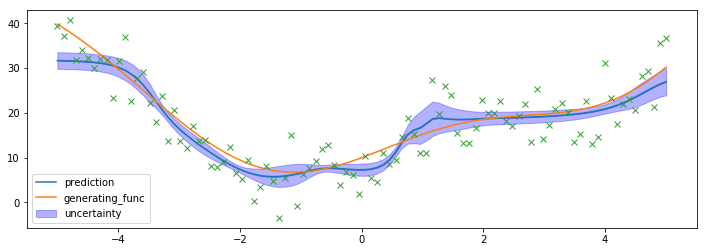

RSME is 4.328338146209717
COVERAGE PROBABILITY is 0.27
MEAN VARIANCE is 1.6905452013015747
COVERAGE/MEAN_VAR is 0.15971178989601886
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.35244718, 0.00032280056108355244)


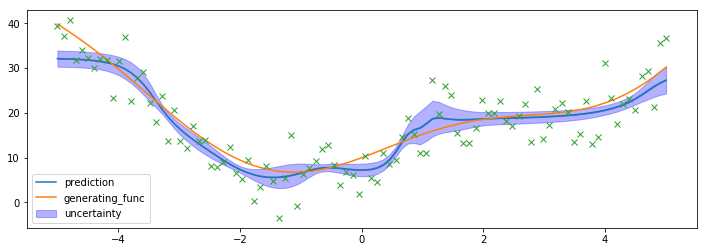

RSME is 4.285094261169434
COVERAGE PROBABILITY is 0.27
MEAN VARIANCE is 1.6501716375350952
COVERAGE/MEAN_VAR is 0.1636193435025378
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.37289554, 0.00013299666996005453)


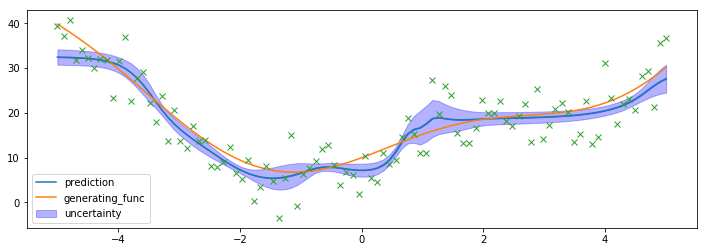

RSME is 4.244973182678223
COVERAGE PROBABILITY is 0.26
MEAN VARIANCE is 1.6454815864562988
COVERAGE/MEAN_VAR is 0.158008453051082
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.38334766, 8.258187588529438e-05)


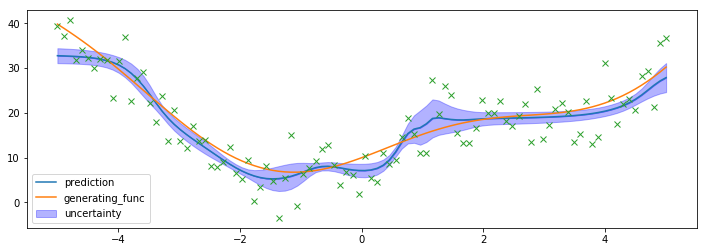

RSME is 4.214468479156494
COVERAGE PROBABILITY is 0.27
MEAN VARIANCE is 1.674604058265686
COVERAGE/MEAN_VAR is 0.16123214240841335
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.38889295, 6.371147205790119e-05)


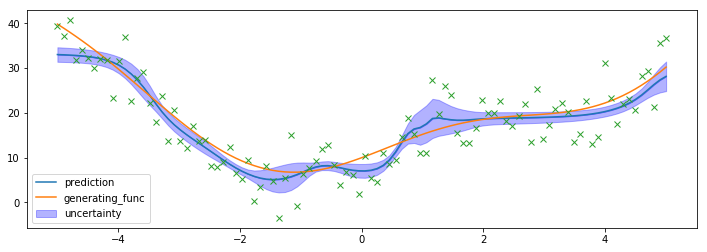

RSME is 4.187108993530273
COVERAGE PROBABILITY is 0.28
MEAN VARIANCE is 1.7123608589172363
COVERAGE/MEAN_VAR is 0.16351693542974943
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.38685367, 7.012697418552486e-05)


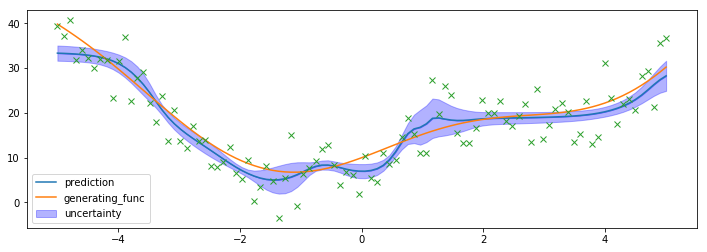

RSME is 4.1804656982421875
COVERAGE PROBABILITY is 0.28
MEAN VARIANCE is 1.752940058708191
COVERAGE/MEAN_VAR is 0.15973164547699528
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.38457057, 7.80208776317748e-05)


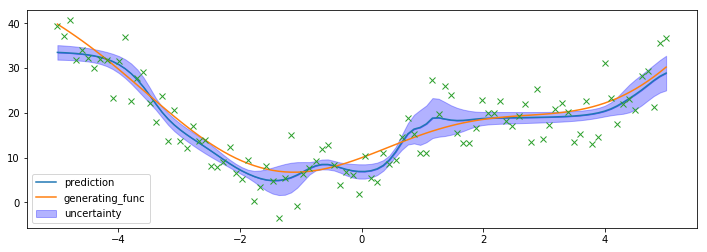

RSME is 4.131284236907959
COVERAGE PROBABILITY is 0.28
MEAN VARIANCE is 1.848821759223938
COVERAGE/MEAN_VAR is 0.1514478064762354
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3505163, 0.00034993049095432584)


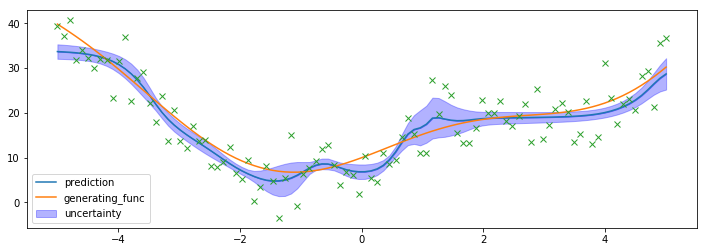

RSME is 4.132933139801025
COVERAGE PROBABILITY is 0.28
MEAN VARIANCE is 1.7706177234649658
COVERAGE/MEAN_VAR is 0.15813690120081994
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39042667, 5.9251531066842356e-05)


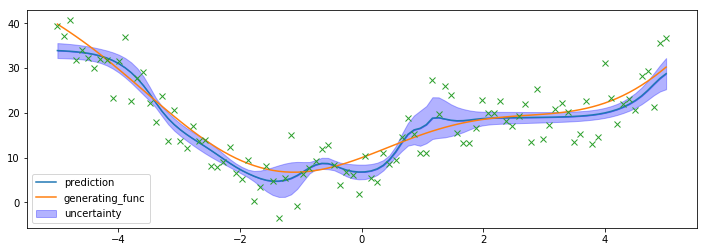

RSME is 4.128927230834961
COVERAGE PROBABILITY is 0.28
MEAN VARIANCE is 1.7889066934585571
COVERAGE/MEAN_VAR is 0.1565201813061955
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.38558736, 7.440829604603995e-05)


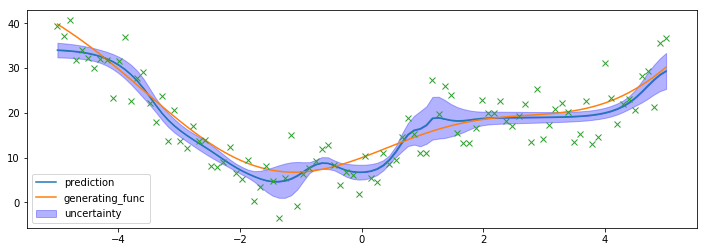

RSME is 4.082545757293701
COVERAGE PROBABILITY is 0.28
MEAN VARIANCE is 1.8383078575134277
COVERAGE/MEAN_VAR is 0.15231398748343478
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39255032, 5.3555123892069494e-05)


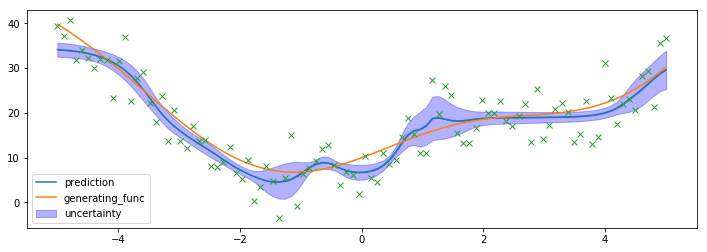

RSME is 4.064752101898193
COVERAGE PROBABILITY is 0.31
MEAN VARIANCE is 1.948174238204956
COVERAGE/MEAN_VAR is 0.15912334426803293
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3533571, 0.00031069972121995377)


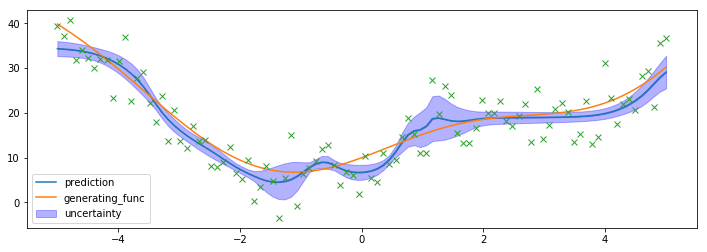

RSME is 4.089523792266846
COVERAGE PROBABILITY is 0.26
MEAN VARIANCE is 1.8597931861877441
COVERAGE/MEAN_VAR is 0.1398004906841041
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3915382, 5.620307470715693e-05)


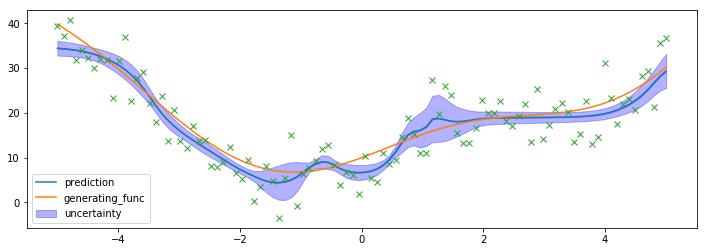

RSME is 4.07103157043457
COVERAGE PROBABILITY is 0.27
MEAN VARIANCE is 1.8830468654632568
COVERAGE/MEAN_VAR is 0.14338464164224404
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.3960119, 4.535254808918071e-05)


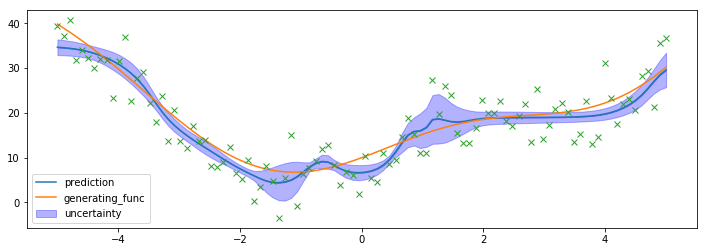

RSME is 4.065439701080322
COVERAGE PROBABILITY is 0.26
MEAN VARIANCE is 1.9133201837539673
COVERAGE/MEAN_VAR is 0.13588943565622955
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39516434, 4.724474511354509e-05)


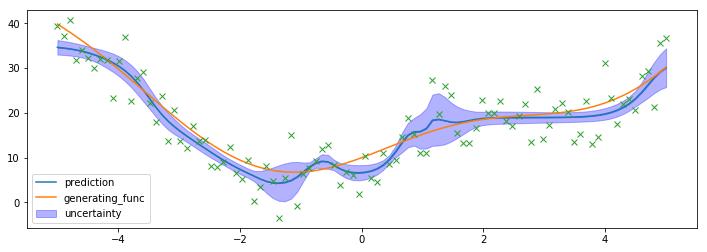

RSME is 4.034086227416992
COVERAGE PROBABILITY is 0.27
MEAN VARIANCE is 1.9697539806365967
COVERAGE/MEAN_VAR is 0.13707295563517016
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.403996, 3.068950694728529e-05)


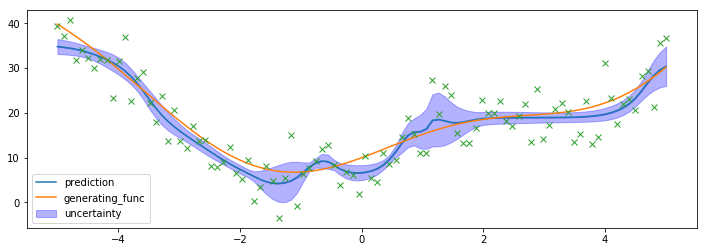

RSME is 4.020226001739502
COVERAGE PROBABILITY is 0.29
MEAN VARIANCE is 1.9519463777542114
COVERAGE/MEAN_VAR is 0.14856965504024552
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39925924, 3.873810256329193e-05)
RSME is 4.020226001739502
COVERAGE PROBABILITY is 0.29
MEAN VARIANCE is 1.9519463777542114
COVERAGE/MEAN_VAR is 0.14856965504024552
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.39925924, 3.873810256329193e-05)


{'NLPD': -4.515458106994629,
 'correlation between error and variance': 0.40637866,
 'coverage probability': 0.28,
 'rsme': 4.0349665}

In [12]:
gauss_error_list = []
for i in range(num_eps*5):
    bootstrap.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = bootstrap.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        #bootstrap_var = bootstrap_var**2
        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)
        
evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

bootstrap.self_evaluate(X,y)

# Old Stuff, can probably be deleted, kept for security reasons

In [13]:
vanilla.train(X,y)
bootstrap.train(X,y)

In [ ]:
vanilla_pred_dict = vanilla.predict(X)
vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
bootstrap_pred_dict = bootstrap.predict(X)
bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_dict)
plot_prediction(X,
                vanilla_preds,
                sorted_index,
                vanilla_var**2)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

In [ ]:
#gauss_error_list = []
for i in range(num_eps):
    bootstrap.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = bootstrap.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [ ]:
evaluate_model(X,y,vanilla_preds,var=vanilla_var**2)

In [ ]:
evaluate_model(X,y,bootstrap_preds,var=bootstrap_var**2)

# Hic sunt dracones

In [ ]:
from ensembles import GaussianNetworkEnsemble, GaussianLRNetworkEnsemble


In [ ]:
gauss = GaussianNetworkEnsemble(estimator_stats = ensemble)

In [ ]:
gauss_dict = gauss.predict(X)

In [ ]:
mean,std = get_mean_var(gauss_dict)

In [ ]:
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

In [ ]:
#gauss_error_list = []
for i in range(num_eps):
    gauss.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = gauss.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [ ]:
gauss.train(X,y)

In [ ]:
gauss_dict = gauss.predict(X)
mean,std = get_mean_var(gauss_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Learning Rate stuff


In [ ]:
gauss_lr = GaussianLRNetworkEnsemble(estimator_stats = ensemble)

In [ ]:
gauss_lr_dict = gauss_lr.predict(X)
mean,std = get_mean_var(gauss_lr_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

In [ ]:
#gauss_error_list = []
for i in range(num_eps):
    gauss_lr.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = gauss_lr.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [ ]:
gauss_lr.train(X,y)

In [ ]:
gauss_lr_dict = gauss_lr.predict(X)
mean,std = get_mean_var(gauss_lr_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)